In this secound part I use my GPU with Rapide for imputing the data and isolate the statsical features and compare this to a random forest. I found not the same vallue are use in random forest compare copare to ANOVA, regression, correlation vallue. I compare two model one with to 20% statical vallue to a full randome forest and founs the same accurncy but the model that use 20% top value really more quick.

In [1]:
import cudf
from sklearn.feature_selection import r_regression, f_regression, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
import seaborn as sns
from cuml import PCA
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import cupy as cp
import numpy as np
import time

In [2]:
df = cudf.read_parquet('.venv/Lib/data_reduce.parquet')
#df = df.sample(frac=0.01, random_state=0)
date = df.pop('S_2')

In [3]:
df = cudf.get_dummies(df, dtype= 'Int8')

In [4]:
df = df.astype('float32')

In [5]:
df = df.fillna(0)

In [6]:
y= df['target']
X = df.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train = cudf.DataFrame.from_pandas(X_train)
X_test = cudf.DataFrame.from_pandas(X_test)
y_train = cudf.Series(y_train)
y_test = cudf.Series(y_test)

In [8]:
# Feature Selection using correlation
correlations = r_regression(X_train.to_pandas(), y_train.to_pandas())
print('correlation done')

# ANOVA and Mutual Information
print('linear regression start')
f_values, p_values = f_regression(X_train.to_pandas(), y_train.to_pandas())
print('ANOVA start')
ANOVA_statistic, ANOVA_p_values = f_classif(X_train.to_pandas(), y_train.to_pandas())

# Store the results in a DataFrame
result_df = cudf.DataFrame({
    'Feature': X_train.columns,
    'P-value': p_values,
    'f_values': f_values,
    'Correlation': correlations,
    'ANOVA_statistic': ANOVA_statistic,
    'ANOVA_p_values': ANOVA_p_values

})

result_df.to_csv('result_df_1.csv')
print(result_df.head())

correlation done
linear regression start
ANOVA start
  Feature  P-value      f_values  Correlation  ANOVA_statistic  ANOVA_p_values
0     P_2      0.0  2.370268e+06    -0.590596     2.462521e+06             0.0
1    D_39      0.0  1.488438e+05     0.180392     1.509400e+05             0.0
2     B_1      0.0  7.903515e+05     0.389280     7.952185e+05             0.0
3     B_2      0.0  1.343244e+06    -0.482558     1.369371e+06             0.0
4     R_1      0.0  6.788496e+05     0.364696     6.748587e+05             0.0


/tmp/ipykernel_13050/3492951139.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='f_values', x='Feature', data=result_df.to_pandas(), palette='magma')
/tmp/ipykernel_13050/3492951139.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Correlation', x='Feature', data=result_df.to_pandas(), palette='magma')
/tmp/ipykernel_13050/3492951139.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ANOVA_statistic', x='Feature', data=result_df.to_pandas(), palette='magma')


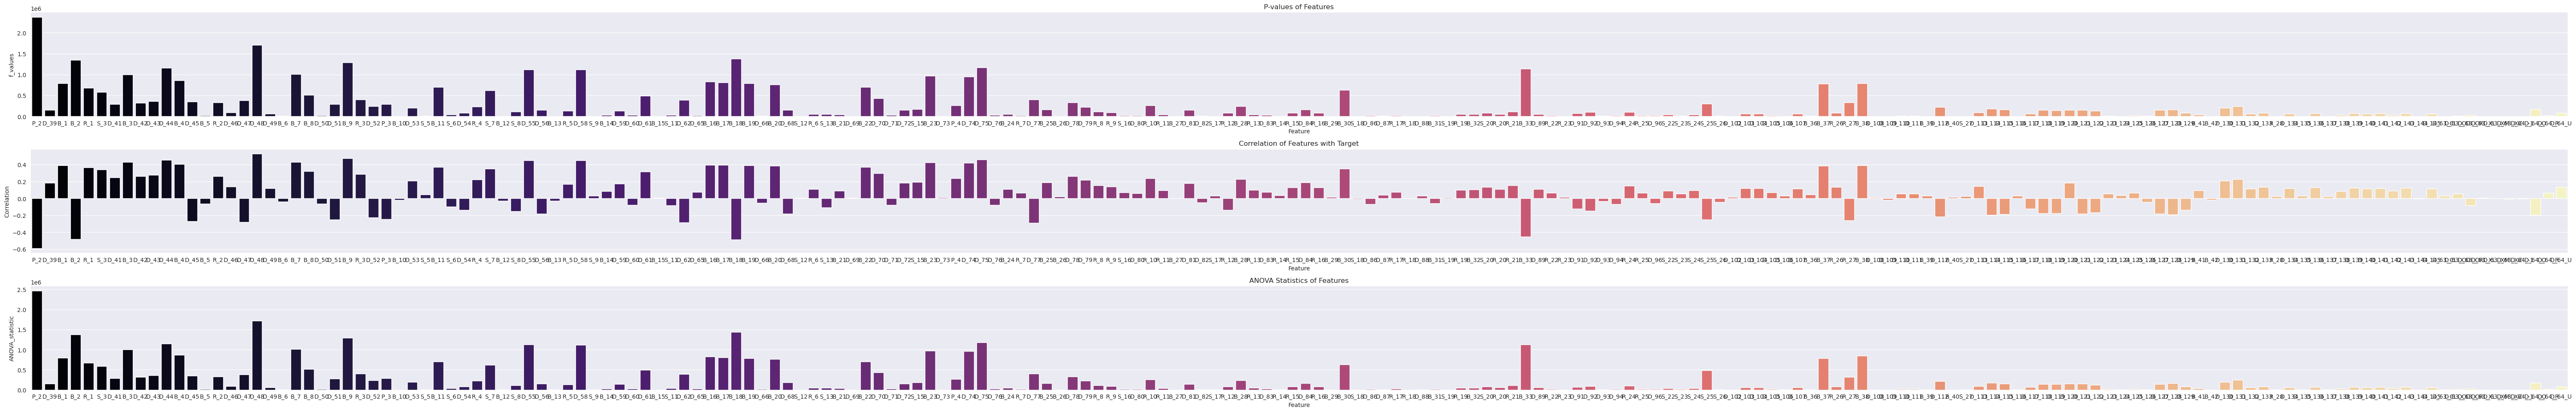

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(62, 10))

plt.subplot(3, 1, 1)
sns.barplot(y='f_values', x='Feature', data=result_df.to_pandas(), palette='magma')
plt.title('P-values of Features')

plt.subplot(3, 1, 2)
sns.barplot(y='Correlation', x='Feature', data=result_df.to_pandas(), palette='magma')
plt.title('Correlation of Features with Target')


plt.subplot(3, 1, 3)
sns.barplot(y='ANOVA_statistic', x='Feature', data=result_df.to_pandas(), palette='magma')
plt.title('ANOVA Statistics of Features')

plt.tight_layout()
plt.show()
plt.savefig('mutliplot.png') 

In [10]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
# Predictions and Metrics
y_pred = clf.predict(X_test)

# Convert cuDF Series to NumPy arrays
y_test_np = y_test.to_numpy()
y_pred_np = y_pred.to_numpy()

# Calculate metrics using NumPy arrays
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("Classification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['Non-Fraud', 'Fraud']))


Accuracy: 0.8809942411173913
Precision: 0.7671969477230639
Recall: 0.7492346410711757
F1 Score: 0.7581094116025906
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.92      0.92    830930
       Fraud       0.77      0.75      0.76    275361

    accuracy                           0.88   1106291
   macro avg       0.84      0.84      0.84   1106291
weighted avg       0.88      0.88      0.88   1106291


In [12]:
# Initialize and train the model
clf = XGBClassifier(device = "cuda")
clf.fit(X_train.to_pandas(), y_train.to_pandas())

# Get feature importances
feature_importances = clf.feature_importances_

# Store the results in a DataFrame
importance_df = cudf.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

result_df.to_csv('importance_df.csv')
print(importance_df.head())

  Feature  Importance
0     P_2    0.220424
1    D_39    0.006761
2     B_1    0.067044
3     B_2    0.028124
4     R_1    0.020485


start PCA
[W] [13:50:42.316338] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


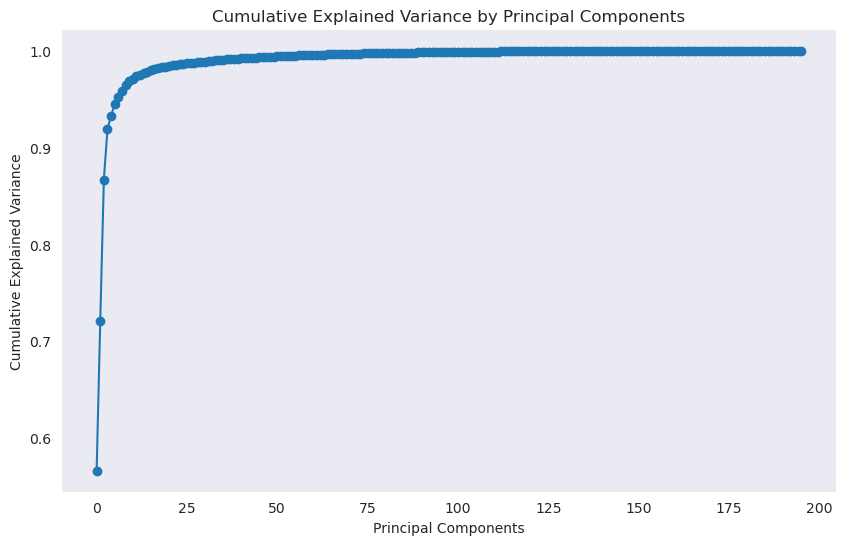

<Figure size 640x480 with 0 Axes>

In [13]:
# PCA
print('start PCA')
pca = PCA()
pca.fit(X_train)

explained_variance_cupy = pca.explained_variance_ratio_.to_cupy()

plt.figure(figsize=(10, 6))
plt.plot(cp.asnumpy(cp.cumsum(explained_variance_cupy)), marker='o')
plt.grid(axis="both")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Principal Components")
sns.despine()
plt.show()
plt.savefig('PCA_cumulative.png')

In [14]:
result_df = cudf.merge(importance_df, result_df, on='Feature')
result_df.to_csv('result_df.csv')

In [15]:
# Convert to pandas DataFrame
df_cpu = df.to_pandas()

# Write to Parquet using pandas
df_cpu.to_parquet('df.parquet')


In [16]:
result_df['Correlation abs'] = result_df['Correlation'].abs()

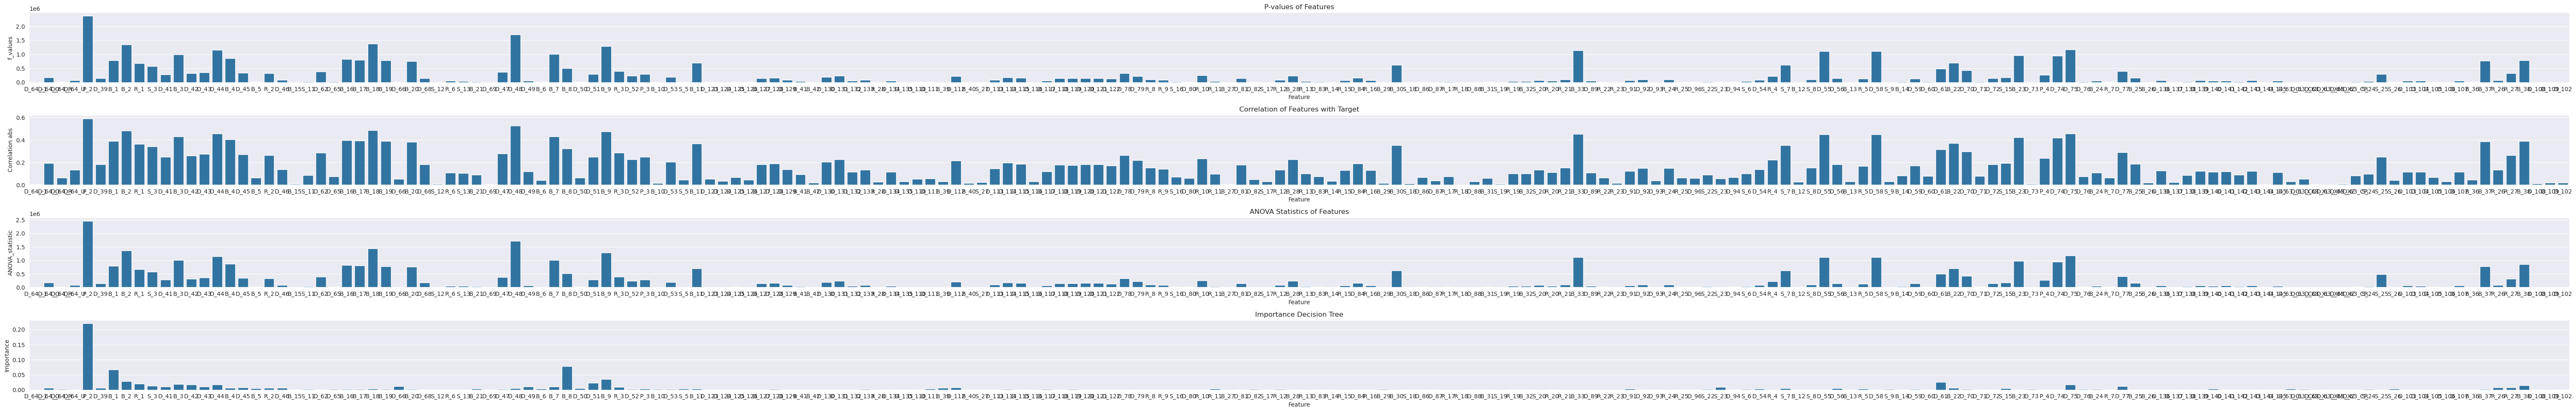

<Figure size 640x480 with 0 Axes>

In [59]:
plt.figure(figsize=(62, 10))

plt.subplot(4, 1, 1)
sns.barplot(y='f_values', x='Feature', data=result_df.to_pandas())
plt.title('P-values of Features')

plt.subplot(4, 1, 2)
sns.barplot(y='Correlation abs', x='Feature', data=result_df.to_pandas())
plt.title('Correlation of Features with Target')


plt.subplot(4, 1, 3)
sns.barplot(y='ANOVA_statistic', x='Feature', data=result_df.to_pandas())
plt.title('ANOVA Statistics of Features')

plt.subplot(4, 1, 4)
sns.barplot(y='Importance', x='Feature', data=result_df.to_pandas())
plt.title('Importance Decision Tree')

plt.tight_layout()
plt.show()
plt.savefig('mutliplot_4.jpg')

In [18]:
result_df.head()

,Feature,Importance,P-value,f_values,Correlation,ANOVA_statistic,ANOVA_p_values,Correlation abs
0,D_64_-1,0.000000,9.329746e-30,1.283688e+02,-0.005386,1.285428e+02,8.546856e-30,0.005386
1,D_64_O,0.006198,0.000000e+00,1.737631e+05,-0.194380,1.740078e+05,0.000000e+00,0.194380
2,D_64_R,0.001872,0.000000e+00,1.869045e+04,0.064853,1.871587e+04,0.000000e+00,0.064853
3,D_64_U,0.001344,0.000000e+00,8.088852e+04,0.133982,8.099996e+04,0.000000e+00,0.133982
4,P_2,0.220424,0.000000e+00,2.370268e+06,-0.590596,2.462521e+06,0.000000e+00,0.590596


In [19]:
num_features = len(result_df)
top_20_percent_cutoff = int(0.2 * num_features)

In [27]:
# Top 20% by ANOVA statistic
top_features_anova = result_df.nlargest(top_20_percent_cutoff, 'ANOVA_statistic')['Feature'].to_arrow().to_pylist()

# Top 20% by absolute Correlation
top_features_corr = result_df.nlargest(top_20_percent_cutoff, 'Correlation abs')['Feature'].to_arrow().to_pylist()

# Top 20% by f-values
top_features_fvalues = result_df.nlargest(top_20_percent_cutoff, 'f_values')['Feature'].to_arrow().to_pylist()

# Combine all top features into one list and remove duplicates
top_features = list(set(top_features_anova + top_features_corr + top_features_fvalues))

# Print the combined list of top features
print(f'Combined list of unique top features: {top_features}')

Combined list of unique top features: ['D_78', 'D_45', 'S_7', 'D_55', 'B_8', 'R_2', 'B_37', 'S_3', 'D_58', 'D_61', 'D_47', 'D_44', 'B_38', 'R_1', 'B_3', 'B_20', 'B_33', 'B_11', 'D_77', 'B_9', 'D_70', 'B_17', 'D_48', 'B_18', 'D_74', 'B_19', 'B_30', 'B_2', 'R_3', 'B_16', 'D_62', 'D_43', 'B_7', 'B_4', 'B_23', 'P_2', 'B_1', 'D_75', 'B_22', 'S_25']


In [36]:
print(len(top_features))
print(len(top_features_anova))
print(len(top_features_corr))
print(len(top_features_fvalues))

40
39
39
39


In [33]:
print(f'top Anova{top_features_anova}')
print(f'top Correlation{top_features_corr}')
print(f'top regression {top_features_fvalues}')

top Anova['P_2', 'D_48', 'B_18', 'B_2', 'B_9', 'D_75', 'D_44', 'D_55', 'B_33', 'D_58', 'B_7', 'B_3', 'B_23', 'D_74', 'B_4', 'B_38', 'B_16', 'B_17', 'B_1', 'B_37', 'B_19', 'B_20', 'B_11', 'B_22', 'R_1', 'B_30', 'S_7', 'S_3', 'B_8', 'D_61', 'S_25', 'D_70', 'D_77', 'R_3', 'D_62', 'D_47', 'D_43', 'D_45', 'R_2']
top Correlation['P_2', 'D_48', 'B_18', 'B_2', 'B_9', 'D_75', 'D_44', 'B_33', 'D_58', 'D_55', 'B_7', 'B_3', 'B_23', 'D_74', 'B_4', 'B_16', 'B_17', 'B_1', 'B_38', 'B_19', 'B_37', 'B_20', 'B_22', 'B_11', 'R_1', 'B_30', 'S_7', 'S_3', 'B_8', 'D_61', 'D_70', 'D_77', 'R_3', 'D_62', 'D_47', 'D_43', 'D_45', 'R_2', 'D_78']
top regression ['P_2', 'D_48', 'B_18', 'B_2', 'B_9', 'D_75', 'D_44', 'B_33', 'D_58', 'D_55', 'B_7', 'B_3', 'B_23', 'D_74', 'B_4', 'B_16', 'B_17', 'B_1', 'B_38', 'B_19', 'B_37', 'B_20', 'B_22', 'B_11', 'R_1', 'B_30', 'S_7', 'S_3', 'B_8', 'D_61', 'D_70', 'D_77', 'R_3', 'D_62', 'D_47', 'D_43', 'D_45', 'R_2', 'D_78']


In [34]:
uncommun_features = set(top_features_anova) - set(top_features_corr) - set(top_features_fvalues)
uncommun_features
#found in ANOVA

{'S_25'}

In [37]:
y_lim = df['target']
X_lim = df[top_features].reset_index('code')
X_lim = X_lim.set_index('code')

In [38]:
# Prepare arrays to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [39]:
X_train_np = X_lim.to_pandas().values
y_train_np = y_lim.to_pandas().values

In [40]:
len(X_lim.columns)

40

In [41]:
miss = set(X_lim.columns) - set(top_features)
miss

set()

In [48]:
start_time = time.time()

In [49]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=True)

In [50]:
# Loop over KFold splits for importance feature
for train_index, test_index in kf.split(X_train_np, y_train_np):
    # Indexing using numpy arrays or pandas DataFrames
    X_train_fold, X_test_fold = X_train_np[train_index], X_train_np[test_index]
    y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]
    
    # Train the XGBoost model
    xgb_model = xgb.XGBRFRegressor(
        colsample_bynode=0.8,
        learning_rate=1,
        max_depth=5,
        num_parallel_tree=100,
        objective="binary:logistic",
        subsample=0.8,
        tree_method="hist",
        device="cuda",
        random_state=42
    )
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred_fold_prob = xgb_model.predict(X_test_fold)
    
    # Convert probabilities to binary predictions (using 0.5 as the threshold)
    y_pred_fold = (y_pred_fold_prob > 0.5).astype(int)
    
    # Calculate metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold)
    recall = recall_score(y_test_fold, y_pred_fold)
    f1 = f1_score(y_test_fold, y_pred_fold)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Print metrics for the current fold
    print(f'Fold Accuracy: {accuracy:.4f}')
    print(f'Fold Precision: {precision:.4f}')
    print(f'Fold Recall: {recall:.4f}')
    print(f'Fold F1 Score: {f1:.4f}')
    print(confusion_matrix(y_test_fold, y_pred_fold))
    print(classification_report(y_test_fold, y_pred_fold, target_names=['Non-Fraud', 'Fraud']))

# Calculate and print average metrics
print(f'Average Accuracy: {np.mean(accuracies):.4f}')
print(f'Average Precision: {np.mean(precisions):.4f}')
print(f'Average Recall: {np.mean(recalls):.4f}')
print(f'Average F1 Score: {np.mean(f1_scores):.4f}')

Fold Accuracy: 0.8539
Fold Precision: 0.6869
Fold Recall: 0.7593
Fold F1 Score: 0.7213
[[1471173  190601]
 [ 132562  418244]]
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.89      0.90   1661774
       Fraud       0.69      0.76      0.72    550806

    accuracy                           0.85   2212580
   macro avg       0.80      0.82      0.81   2212580
weighted avg       0.86      0.85      0.86   2212580
Fold Accuracy: 0.8543
Fold Precision: 0.6912
Fold Recall: 0.7517
Fold F1 Score: 0.7202
[[1475579  185299]
 [ 136971  414731]]
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.89      0.90   1660878
       Fraud       0.69      0.75      0.72    551702

    accuracy                           0.85   2212580
   macro avg       0.80      0.82      0.81   2212580
weighted avg       0.86      0.85      0.86   2212580

Average Accuracy: 0.8531
Average Precision: 0.6870
Average Recall: 0.7539
Average F1 Score: 0.7

In [51]:
end_time = time.time()
time_top_features = end_time - start_time
print(f'Time for model with top 20% features: {time_top_features:.2f} seconds')

Time for model with top 20% features: 90.86 seconds


In [52]:
start_time = time.time()

In [53]:
# Loop over KFold splits with all features
y = df['target']
X = df.drop('target', axis=1)

# Prepare arrays to store metrics
accuracies_full = []
precisions_full = []
recalls_full = []
f1_scores_full = []

X_train_np = X_train.to_pandas().values
y_train_np = y_train.to_pandas().values

for train_index, test_index in kf.split(X_train_np, y_train_np):
    # Indexing using numpy arrays or pandas DataFrames
    X_train_fold, X_test_fold = X_train_np[train_index], X_train_np[test_index]
    y_train_fold, y_test_fold = y_train_np[train_index], y_train_np[test_index]
    
    # Train the XGBoost model
    xgb_model = xgb.XGBRFRegressor(
        colsample_bynode=0.8,
        learning_rate=1,
        max_depth=5,
        num_parallel_tree=100,
        objective="binary:logistic",
        subsample=0.8,
        tree_method="hist",
        device="cuda",
        random_state=42
    )
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred_fold_prob = xgb_model.predict(X_test_fold)
    
    # Convert probabilities to binary predictions (using 0.5 as the threshold)
    y_pred_fold = (y_pred_fold_prob > 0.5).astype(int)
    
    # Calculate metrics for this fold
    accuracy_full = accuracy_score(y_test_fold, y_pred_fold)
    precision_full = precision_score(y_test_fold, y_pred_fold)
    recall_full = recall_score(y_test_fold, y_pred_fold)
    f1_full = f1_score(y_test_fold, y_pred_fold)

    # Append metrics to the lists
    accuracies_full.append(accuracy_full)
    precisions_full.append(precision_full)
    recalls_full.append(recall_full)
    f1_scores_full.append(f1_full)

    # Print metrics for the current fold
    print(f'Fold Accuracy: {accuracy_full:.4f}')
    print(f'Fold Precision: {precision_full:.4f}')
    print(f'Fold Recall: {recall_full:.4f}')
    print(f'Fold F1 Score: {f1_full:.4f}')
    print(confusion_matrix(y_test_fold, y_pred_fold))
    print(classification_report(y_test_fold, y_pred_fold, target_names=['Non-Fraud', 'Fraud']))

# Calculate and print average metrics
print(f'Average Accuracy: {np.mean(accuracies_full):.4f}')
print(f'Average Precision: {np.mean(precisions_full):.4f}')
print(f'Average Recall: {np.mean(recalls_full):.4f}')
print(f'Average F1 Score: {np.mean(f1_scores_full):.4f}')

Time = time.process_time()
print(f'Time')

Fold Accuracy: 0.8543
Fold Precision: 0.6920
Fold Recall: 0.7483
Fold F1 Score: 0.7191
[[1477898  183559]
 [ 138715  412408]]
              precision    recall  f1-score   support

   Non-Fraud       0.91      0.89      0.90   1661457
       Fraud       0.69      0.75      0.72    551123

    accuracy                           0.85   2212580
   macro avg       0.80      0.82      0.81   2212580
weighted avg       0.86      0.85      0.86   2212580
Fold Accuracy: 0.8543
Fold Precision: 0.6878
Fold Recall: 0.7610
Fold F1 Score: 0.7225
[[1470686  190509]
 [ 131759  419626]]
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.89      0.90   1661195
       Fraud       0.69      0.76      0.72    551385

    accuracy                           0.85   2212580
   macro avg       0.80      0.82      0.81   2212580
weighted avg       0.86      0.85      0.86   2212580

Average Accuracy: 0.8543
Average Precision: 0.6899
Average Recall: 0.7547
Average F1 Score: 0.7

In [54]:
end_time = time.time()
time_all_features = end_time - start_time
print(f'Time for model with all features: {time_all_features:.2f} seconds')

Time for model with all features: 125.76 seconds


In [57]:
print(f'Time improvement: {((time_all_features - time_top_features)/time_all_features)*100:.2f} % with top 20% features.')

Time improvement: 27.75 % with top 20% features.
